# Explore signal/price movement relationship

This is an example notebook to explore whether a trading signal results to profitable trades.

- It explores a small set of pairs on Uni v3 on Polygon
- Both long and short are considered (though shorts might be theoretical only, if such a lending market doest not exist in the point of time)

In [1]:
import datetime

import pandas as pd

from tradingstrategy.client import Client
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.execution_context import notebook_execution_context
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.strategy_module import read_strategy_module
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_trading_and_lending_data
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_trading_universe(
    ts: datetime.datetime,
    client: Client,
    execution_context,
    universe_options,
) -> TradingStrategyUniverse:
    
    dataset = load_trading_and_lending_data(
        client,
        execution_context=execution_context,
        universe_options=universe_options,
        # Ask for all Polygon data
        chain_id=ChainId.polygon,
        exchange_slugs={"uniswap-v3"},
        reserve_asset_symbols={"USDC"},
        asset_symbols={"LINK", "WMATIC", "WETH"},
        trading_fee=0.0005,  # Only use pairs at 0.05% fee tier
        time_bucket=TimeBucket.d1,
    )

    universe = TradingStrategyUniverse.create_from_dataset(dataset)

    return universe


client = Client.create_jupyter_client()

strategy_universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    notebook_execution_context,
    UniverseOptions(start_at=pd.Timestamp("2022-01-01"), end_at=pd.Timestamp("2023-11-01")),
)

data_universe = strategy_universe.data_universe

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


### Github viewer mode

Set Plotly chart output mode to static images that Github website notebook viewer can display,
and user can browse the notebook using his web browser and a Github link.

In [2]:
from tradeexecutor.utils.notebook import OutputMode, setup_charting_and_output


setup_charting_and_output(OutputMode.static, image_format="png")

## Explore signal vs price change

Create a function `calculate_signal_vs_profit` which calculates 
- Signal (naive momentum)
- Profit: the last and the best future price we can get
- Allows us to play around with different time windows
- Split between shorts and longs


In [3]:
import numpy as np
from pandas.tseries.frequencies import to_offset

from tradingstrategy.utils.forward_fill import forward_fill
from tradingstrategy.pair import DEXPair

def calculate_signal_vs_profit(df, signal_window: pd.Timedelta, profit_window: pd.Timedelta) -> pd.DataFrame:
    """Calculate signals and profits for all incoming candles."""
    
    # Create entries for past price to be used for signal
    # and future price (used for the price correlation)
    signal_offset = to_offset(signal_window)
    profit_offset = to_offset(profit_window)

    df["prev"] = df["close"].shift(freq=signal_offset)
    df["next"] = df["open"].shift(freq=-profit_offset)

    # Calculate signal from the past and price difference to the future
    df["signal"] = (df["prev"] - df["open"]) / df["open"]
    df["price_diff"] = (df["next"] - df["open"]) / df["open"]  # Get the profit on the final day of profit window

    # On negative signals, we go short.
    # On zero signal and lack of data set side to NA
    df["side"] = pd.NA
    df.loc[df["signal"] > 0, "side"] = "long"
    df.loc[df["signal"] < 0, "side"] = "short"

    # Max and min price wihtin the profit window will determine the profit for longs and shorts respective
    df["max_future_price"] = df["close"].rolling(profit_window.days).max().shift(-profit_window.days) # Get the max profit on the profit window, assuming take profit %
    df["min_future_price"] = df["close"].rolling(profit_window.days).min().shift(-profit_window.days) # Get the max profit on the profit window, assuming take profit %    
    
    # Calculate profit separately for longs and shorts
    # using Pandas Mask
    # https://stackoverflow.com/a/33770421/315168
    #
    # We calculate both profit after X time,
    # and also max take profit, assuming
    # we could do a perfect trailing stop loss
    #
    longs = (df["side"] == "long")
    shorts = (df["side"] == "short")
    df.loc[longs, "profit"] = df["price_diff"]
    df.loc[shorts, "profit"] = -df["price_diff"]
    df.loc[longs, "profit_max"] = (df["max_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price
    df.loc[shorts, "profit_max"] = -(df["min_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price

    df.loc[longs, "desc"] = df.agg('{0[pair]} long'.format, axis=1)
    df.loc[shorts, "desc"] = df.agg('{0[pair]} short'.format, axis=1)

    
    return df
     


Create a function `calculate_signal_vs_price_for_pair` which calculates 
- Calculates the signal vs. for certain trading pair
- Bundle few different pairs to the same `DataFrame` so we can examine them together


In [4]:
def calculate_signal_vs_price_for_pair(pair: DEXPair) -> pd.DataFrame:
    """Calculate signal vs. profit ratio for an individual pair."""
    df = data_universe.candles.get_candles_by_pair(pair)
    assert df is not None

    df = df.copy()

    # Make sure there are no gaps in the data
    df = forward_fill(
        df, 
        freq=data_universe.time_bucket.to_frequency(), 
        columns=("open", "high", "low", "close")
    )

    df["pair"] = pair.get_ticker()
    df = calculate_signal_vs_profit(
        df,
        #signal_window=pd.DateOffset(days=7),
        #profit_window=pd.DateOffset(days=7),
        signal_window=pd.Timedelta(days=8),
        profit_window=pd.Timedelta(days=8),
    )

    
    return df

pairs = data_universe.pairs
eth = calculate_signal_vs_price_for_pair(pairs.get_pair_by_human_description((ChainId.polygon, "uniswap-v3", "WETH", "USDC")))
link = calculate_signal_vs_price_for_pair(pairs.get_pair_by_human_description((ChainId.polygon, "uniswap-v3", "LINK", "USDC")))
matic = calculate_signal_vs_price_for_pair(pairs.get_pair_by_human_description((ChainId.polygon, "uniswap-v3", "WMATIC", "USDC")))

df = pd.concat([eth, link, matic])

pd.set_option('display.min_rows', 36)
display(df)

open         high          low        close         pair  \
timestamp                                                                     
2022-07-07  1184.941609  1252.561586  1178.206991  1237.621415    WETH-USDC   
2022-07-08  1237.497665  1271.872162  1194.458684  1215.787741    WETH-USDC   
2022-07-09  1215.544620  1230.956604  1204.654343  1216.882388    WETH-USDC   
2022-07-10  1216.882388  1218.099818  1153.839213  1166.834199    WETH-USDC   
2022-07-11  1166.950882  1169.287002  1091.985483  1096.033110    WETH-USDC   
2022-07-12  1096.142714  1096.910244  1034.067762  1036.863378    WETH-USDC   
2022-07-13  1036.863378  1116.497411  1011.466657  1114.601072    WETH-USDC   
2022-07-14  1114.712532  1208.515218  1073.579544  1192.429930    WETH-USDC   
2022-07-15  1192.310699  1284.525595  1181.392288  1230.956604    WETH-USDC   
2022-07-16  1230.956604  1395.405877  1192.906974  1356.200105    WETH-USDC   
2022-07-17  1356.200105  1382.765914  1322.320323  1337.480264    WETH-USDC   
2022-07-18  1337.747773  1594.529414  1337.079100  1581.982883    WETH-USDC   
2022-07-19  1581.982883  1630.811151  1495.083225  1544.005887    WETH-USDC   
2022-07-20  1543.697132  1620.407806  1491.201251  1520.867688    WETH-USDC   
2022-07-21  1520.867688  1603.804091  1467.092893  1575.510354    WETH-USDC   
2022-07-22  1575.352819  1644.895900  1520.259493  1534.770049    WETH-USDC   
2022-07-23  1534.770049  1594.848336  1491.648657  1549.109267    WETH-USDC   
2022-07-24  1549.109267  1662.257427  1546.478150  1597.402008    WETH-USDC   
...                 ...          ...          ...          ...          ...   
2023-10-15     0.517335     0.520136     0.513059     0.514909  WMATIC-USDC   
2023-10-16     0.514909     0.541471     0.514446     0.533836  WMATIC-USDC   
2023-10-17     0.533890     0.534424     0.516147     0.519149  WMATIC-USDC   
2023-10-18     0.519149     0.524471     0.507193     0.510858  WMATIC-USDC   
2023-10-19     0.510807     0.519876     0.503706     0.517490  WMATIC-USDC   
2023-10-20     0.517387     0.546092     0.514909     0.535815  WMATIC-USDC   
2023-10-21     0.536029     0.576563     0.533676     0.572599  WMATIC-USDC   
2023-10-22     0.572714     0.611786     0.558686     0.609344  WMATIC-USDC   
2023-10-23     0.609283     0.647216     0.600092     0.636752  WMATIC-USDC   
2023-10-24     0.637007     0.664994     0.617934     0.624581  WMATIC-USDC   
2023-10-25     0.624581     0.648382     0.614975     0.630291  WMATIC-USDC   
2023-10-26     0.630291     0.658246     0.616453     0.632311  WMATIC-USDC   
2023-10-27     0.632311     0.632564     0.601775     0.608917  WMATIC-USDC   
2023-10-28     0.608917     0.626520     0.608674     0.620411  WMATIC-USDC   
2023-10-29     0.620411     0.642123     0.612888     0.638474  WMATIC-USDC   
2023-10-30     0.638537     0.649875     0.626896     0.649420  WMATIC-USDC   
2023-10-31     0.649485     0.656931     0.620349     0.635989  WMATIC-USDC   
2023-11-01     0.635925     0.668929     0.616823     0.668929  WMATIC-USDC   

                   prev         next    signal  price_diff   side  \
timestamp                                                           
2022-07-07          NaN  1192.310699       NaN    0.006219   <NA>   
2022-07-08          NaN  1230.956604       NaN   -0.005286   <NA>   
2022-07-09          NaN  1356.200105       NaN    0.115714   <NA>   
2022-07-10          NaN  1337.747773       NaN    0.099324   <NA>   
2022-07-11          NaN  1581.982883       NaN    0.355655   <NA>   
2022-07-12          NaN  1543.697132       NaN    0.408299   <NA>   
2022-07-13          NaN  1520.867688       NaN    0.466797   <NA>   
2022-07-14          NaN  1575.352819       NaN    0.413237   <NA>   
2022-07-15  1237.621415  1534.770049  0.038002    0.287223   long   
2022-07-16  1215.787741  1549.109267 -0.012323    0.258460  short   
2022-07-17  1216.882388  1597.242284 -0.102727    0.177733  short   
2022-07-18  1166.834199  1437.756380 -0.

## Plot signal vs. price samples

Different scatter charts to examine if there is a correlation between the signal and the profit.

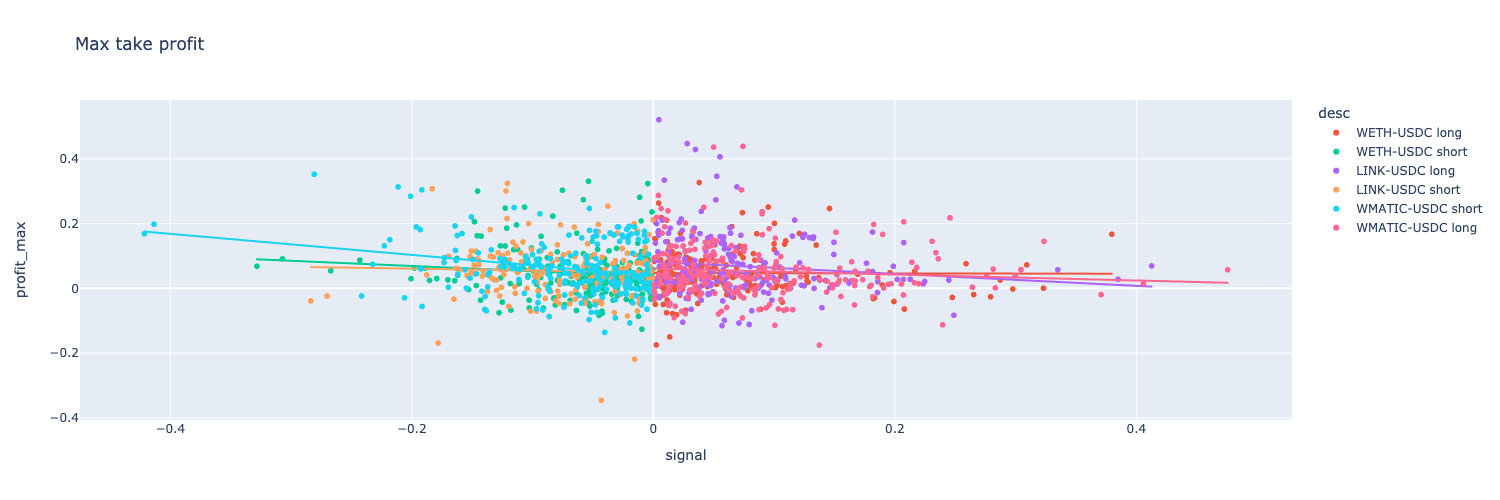

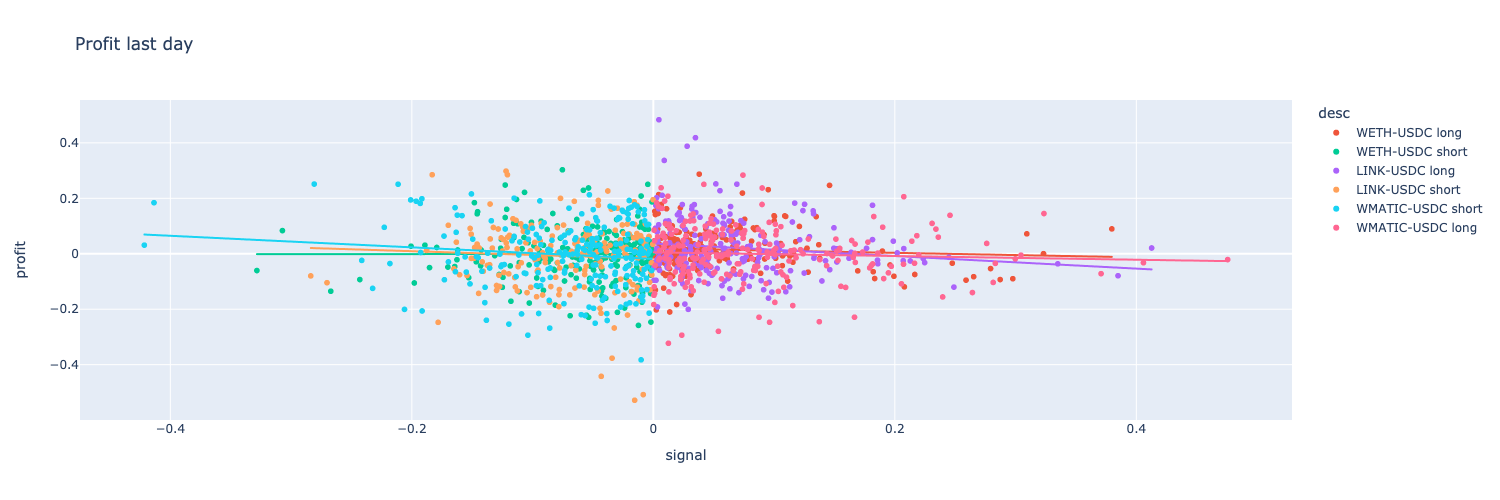

In [5]:
import plotly.express as px
fig = px.scatter(df, x="signal", y="profit_max", trendline="ols", color="desc", title="Max take profit")
fig.show()

fig = px.scatter(df, x="signal", y="profit", trendline="ols", color="desc", title="Profit last day")
fig.show()

### Long only vs. short 

Examine trade types separately to better see if one side is clearly superior.

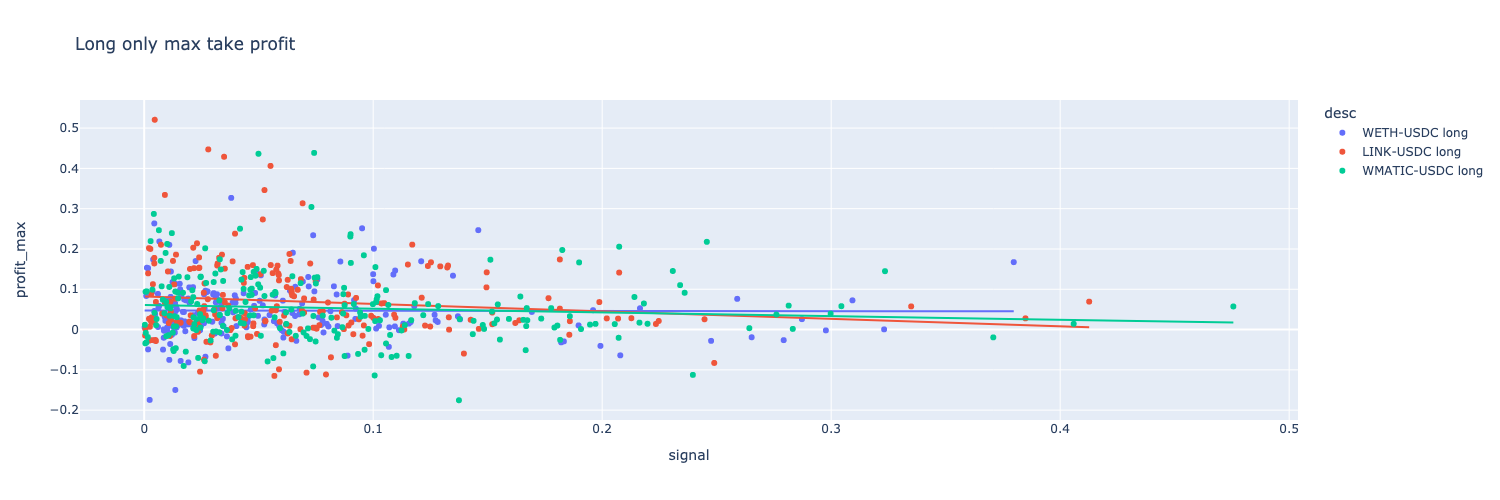

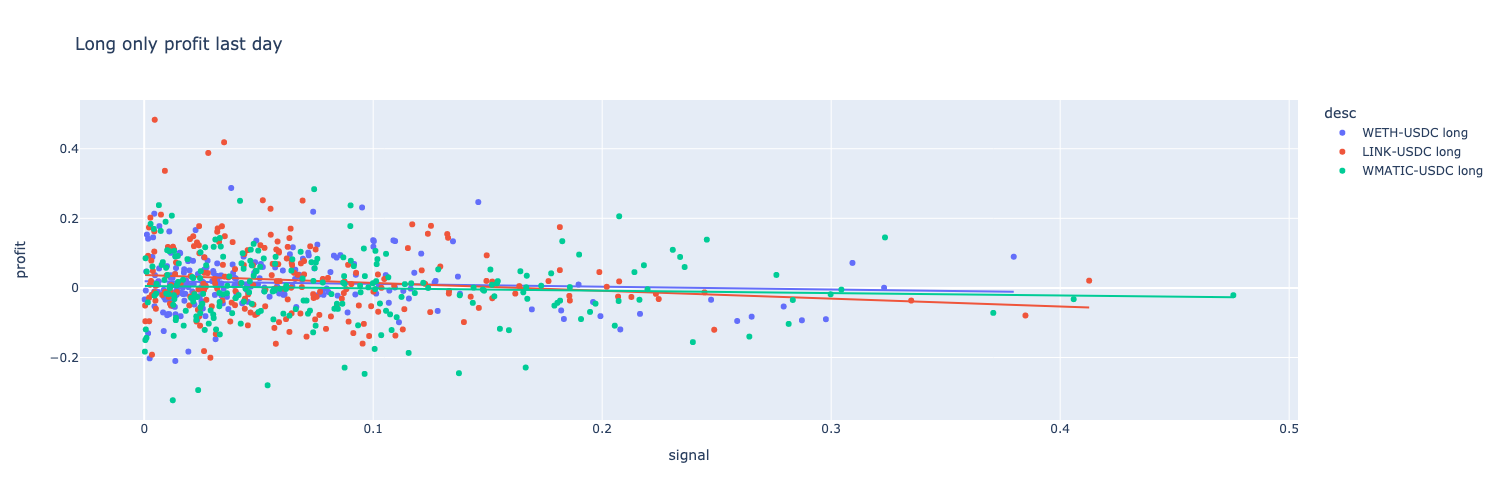

In [6]:
df_long_only = df.loc[df["side"] == "long"]

fig = px.scatter(df_long_only, x="signal", y="profit_max", trendline="ols", color="desc", title="Long only max take profit")
fig.show()

fig = px.scatter(df_long_only, x="signal", y="profit", trendline="ols", color="desc", title="Long only profit last day")
fig.show()

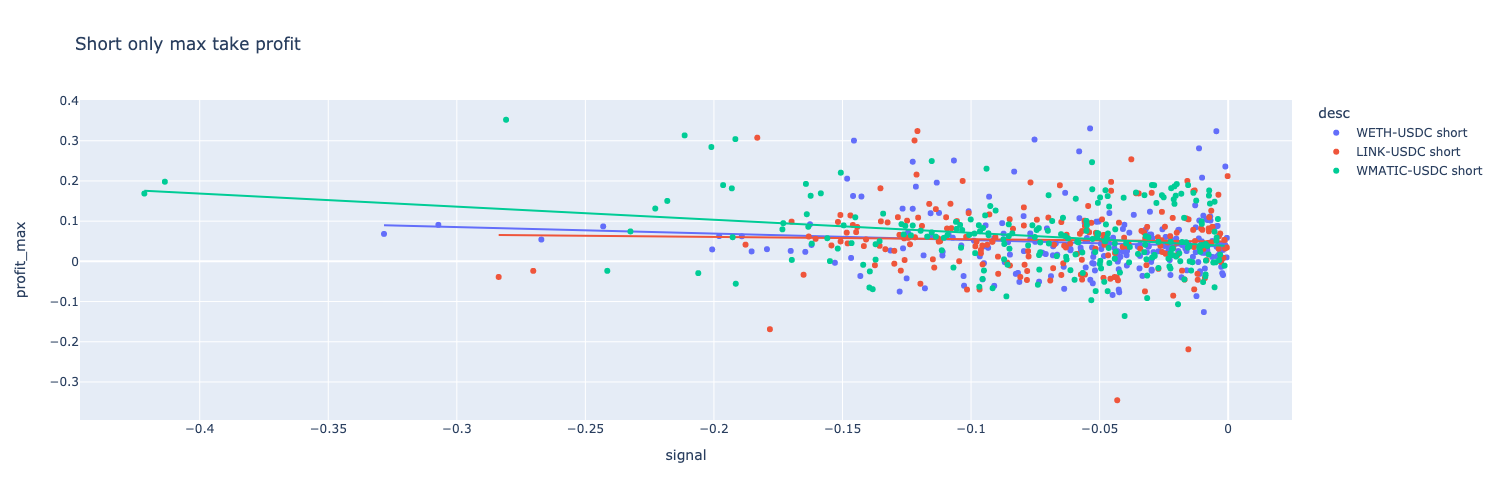

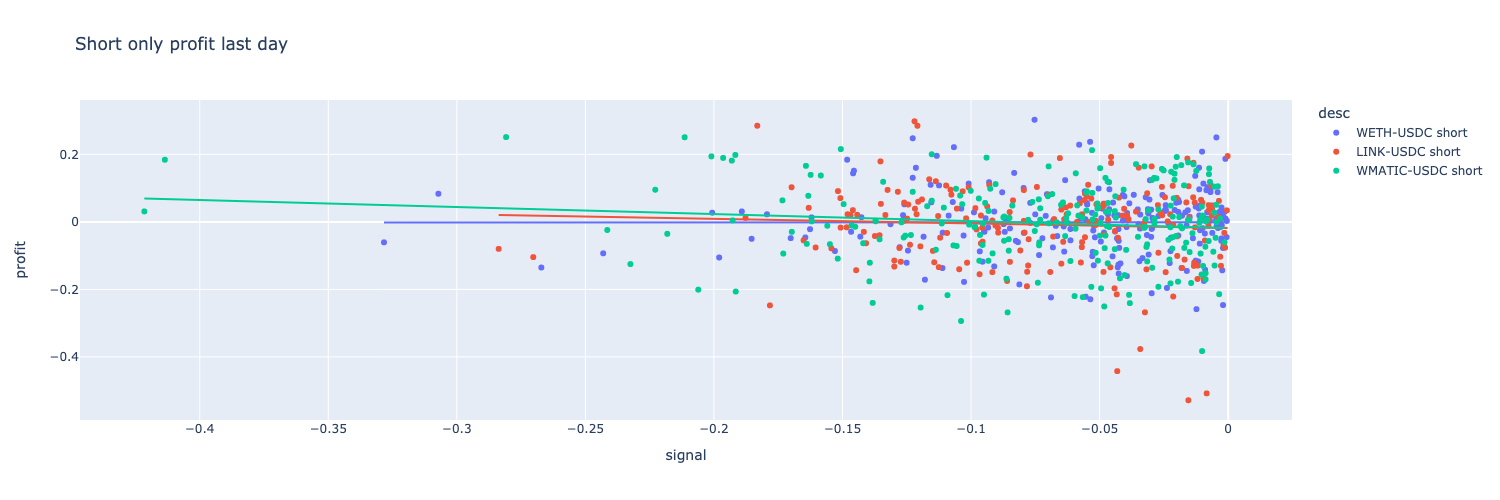

In [7]:
df_short_only = df.loc[df["side"] == "short"]

fig = px.scatter(df_short_only, x="signal", y="profit_max", trendline="ols", color="desc", title="Short only max take profit")
fig.show()

fig = px.scatter(df_short_only, x="signal", y="profit", trendline="ols", color="desc", title="Short only profit last day")
fig.show()

### Filtered signal

Remove low signals below a certain threshold and see if it affects the correlation between the signal and the profit.

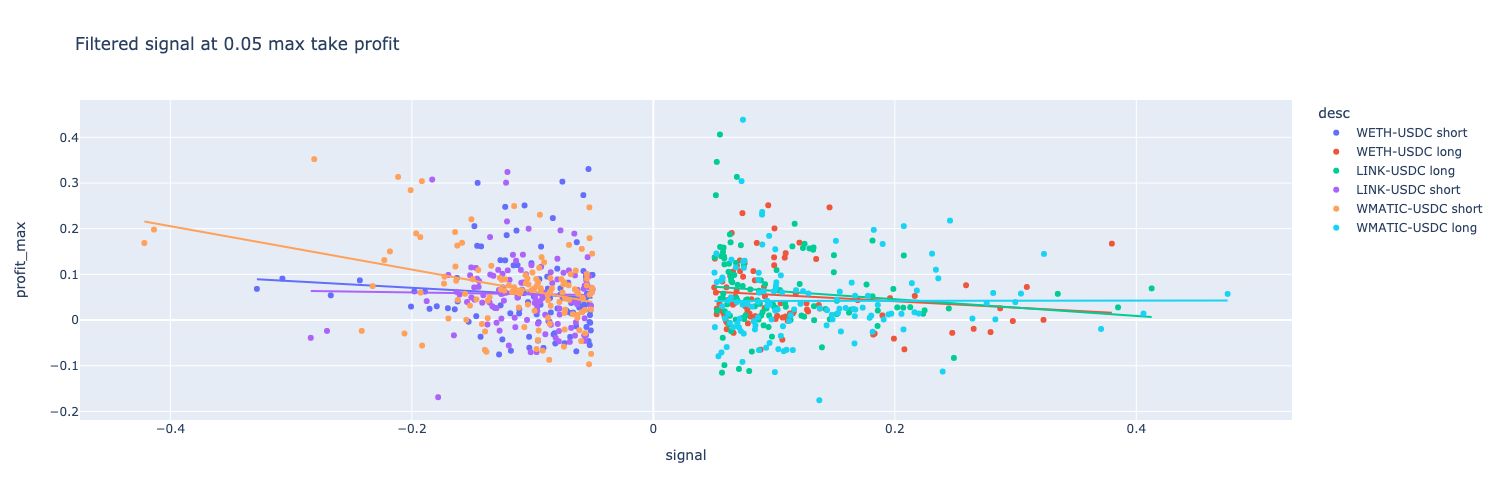

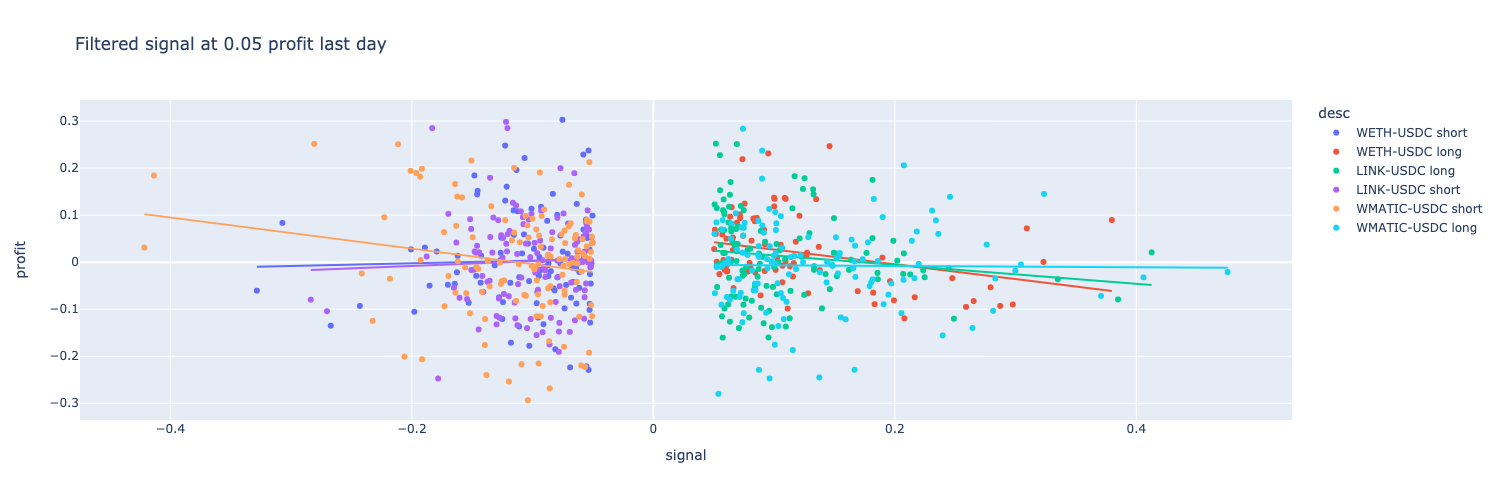

In [8]:

threshold = 0.05

filtered_df = df.loc[abs(df["signal"]) >= threshold]

fig = px.scatter(filtered_df, x="signal", y="profit_max", trendline="ols", color="desc", title=f"Filtered signal at {threshold} max take profit")
fig.show()

fig = px.scatter(filtered_df, x="signal", y="profit", trendline="ols", color="desc", title=f"Filtered signal at {threshold} profit last day")
fig.show()